## Test data

In [1]:
from synthetic_data import JetSequence

tops = JetSequence(filepath='/home/df630/SyntheticJets/data/TTBar_val___1Mfromeach_403030.h5', )
qcd = JetSequence(filepath='/home/df630/SyntheticJets/data/ZJetsToNuNu_val___1Mfromeach_403030.h5', )

tops_seq = tops.map_to_sequence()
tops_bin = tops.seq_to_bins_decoding(tops_seq)
qcd_seq = qcd.map_to_sequence()
qcd_bin = qcd.seq_to_bins_decoding(qcd_seq)


INFO: start token: None
INFO: end token: None
INFO: pad token: -1
INFO: start token: None
INFO: end token: None
INFO: pad token: -1


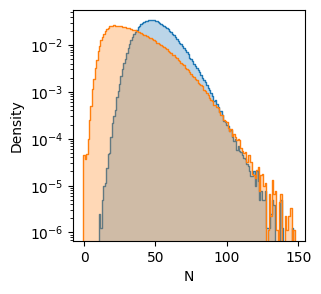

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, _ = plt.subplots(1, 1, figsize=(3, 3))
sns.histplot((tops_seq != tops.pad_token).sum(axis=1), discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)
sns.histplot((qcd_seq != qcd.pad_token).sum(axis=1), discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)

plt.xlabel('N')
plt.ylabel('Density')
plt.yscale('log')
plt.show()

## Generate jet sequences

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import JetGPT2Model

###############################################################################
N = 50_000  # num gen jets
sig_id = "e66587b2c59b4773a97aa4afabd9b095"        # comet run folder
bkg_id = "bfd0ed551863419a8a30e04b5a2fbae6"
path = "/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/"
###############################################################################

In [2]:
#...Tops

tops_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{sig_id}/checkpoints/best.ckpt")
tops_gpt2.top_k = 5000 #tops_gpt2.start_token # remove top_k default cut

prompts = torch.full((N, 1), tops_gpt2.start_token, dtype=torch.long, device=tops_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=[0])
tops_gen_seq = generator.predict(tops_gpt2, dataloaders=prompt_dataloadeer)
tops_gen_seq = torch.cat(tops_gen_seq, dim=0)

np.save(f'{path}{sig_id}/gen_tops_seq_gpt2_top5000.npy', tops_gen_seq)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [4]:
#...QCD

qcd_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{bkg_id}/checkpoints/best.ckpt")
qcd_gpt2.top_k = 5000 #qcd_gpt2.start_token # remove top_k default cut

prompts = torch.full((N, 1), qcd_gpt2.start_token, dtype=torch.long, device=qcd_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=[1])
qcd_gen_seq = generator.predict(qcd_gpt2, dataloaders=prompt_dataloadeer)
qcd_gen_seq = torch.cat(qcd_gen_seq, dim=0)
np.save(f'{path}{bkg_id}/gen_qcd_seq_gpt2_top5000.npy', qcd_gen_seq)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

## validation plots

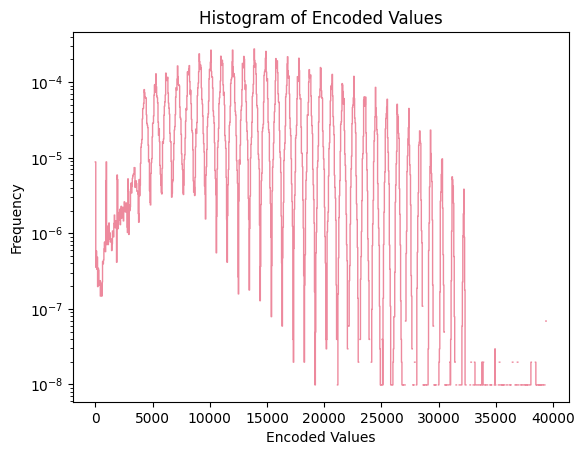

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(tops_gen_seq[tops_gen_seq>=0], lw=1,bins=1000, fill=False, alpha=0.5, label='sample', element='step', stat='density', color='crimson', log_scale=(False, True))
plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.show()

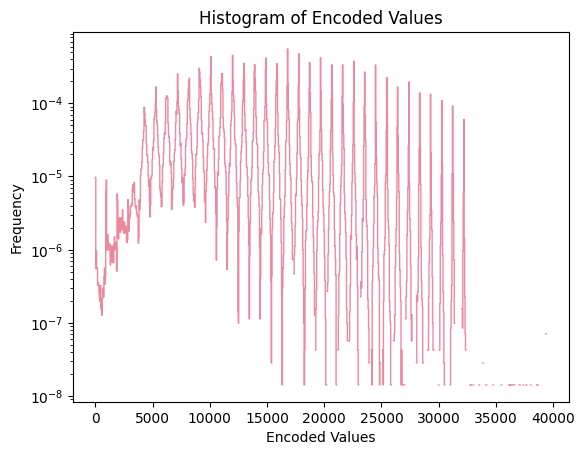

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(qcd_gen_seq[qcd_gen_seq>0], lw=1,bins=1000, fill=False, alpha=0.5, label='sample', element='step', stat='density', color='crimson', log_scale=(False, True))
plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.show()

## Binned jets

In [59]:
# open h5 file load

import h5py
import numpy as np
import pandas as pd

def load_h5_data(file_path):
    with h5py.File(file_path, "r") as f:
        arr = f['discretized/block0_values']
        data = arr[:]
    df = pd.DataFrame(data)
    x = df.to_numpy() 
    x = x.reshape(x.shape[0], -1, 3)
    return x


data = load_h5_data('/home/df630/SyntheticJets/data/TTBar_val___1Mfromeach_403030.h5')

In [82]:
data[...,1][111]

array([14, 16, 14, 14, 16, 15, 14, 14, 14, 14, 15, 15, 15, 15, 16, 13, 15,
        9, 17, 14, 14, 13, 17, 15, 17, 14, 15, 16, 13, 15, 17, 17, 14, 16,
       14, 16, 16, 14, 22, 12, 14, 14, 16, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int16)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import JetGPT2Model
from synthetic_data import JetSequence


###############################################################################
N = 50_000  # num gen jets
sig_id = "17eab02a204343a3969183034847009d"        # comet run folder
bkg_id = "301a89ea04ba46f59c2f39f34ff5f9b9"
path = "/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/"
###############################################################################


#...Test

tops = JetSequence(filepath='/home/df630/SyntheticJets/data/TTBar_test___1Mfromeach_403030.h5', )
qcd = JetSequence(filepath='/home/df630/SyntheticJets/data/ZJetsToNuNu_test___1Mfromeach_403030.h5', )

tops_test_seq = torch.tensor(tops.map_to_sequence()[:N]).long()
tops_test_bins = torch.tensor(tops.seq_to_bins_decoding(tops_test_seq)[:N]).long()
qcd_test_seq = torch.tensor(qcd.map_to_sequence()[:N]).long()
qcd_test_bins = torch.tensor(qcd.seq_to_bins_decoding(qcd_test_seq)[:N]).long()

#...Gen

tops_gen_seq = torch.tensor(np.load(f'{path}{sig_id}/gen_tops_seq_gpt2_top5000_jets1e6.npy'))[:N]
qcd_gen_seq = torch.tensor(np.load(f'{path}{bkg_id}/gen_qcd_seq_gpt2_top5000_jets1e6.npy'))[:N]
tops_gen_bins = tops.seq_to_bins_decoding(tops_gen_seq)
qcd_gen_bins = qcd.seq_to_bins_decoding(qcd_gen_seq)

INFO: start token: None
INFO: end token: None
INFO: pad token: -1
INFO: start token: None
INFO: end token: None
INFO: pad token: -1


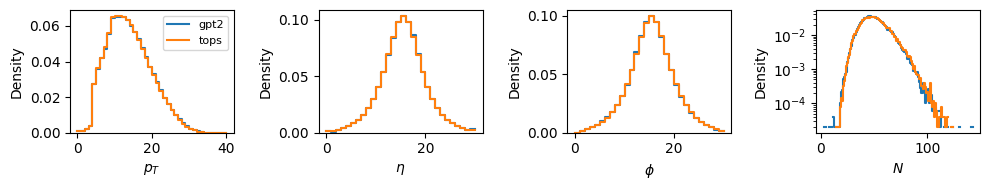

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
sns.histplot(tops_gen_bins[...,0][tops_gen_bins[...,0] >= 0],   bins=np.arange(0,41,1),  fill=False,   label='gpt2', element='step', stat='density', ax=ax[0])
sns.histplot(tops_test_bins[...,0][tops_test_bins[...,0] >= 0],  bins=np.arange(0,41,1),   fill=False, label='tops', element='step', stat='density', ax=ax[0])
sns.histplot(tops_gen_bins[...,1][tops_gen_bins[...,0] >= 0],   bins=np.arange(0,31,1), fill=False,  label='gpt2', element='step', stat='density', ax=ax[1])
sns.histplot(tops_test_bins[...,1][tops_test_bins[...,0] >= 0],   bins=np.arange(0,31,1), fill=False,  label='test', element='step', stat='density', ax=ax[1])
sns.histplot(tops_gen_bins[...,2][tops_gen_bins[...,0] >= 0], bins=np.arange(0,31,1), fill=False,  label='gpt2', element='step', stat='density', ax=ax[2])
sns.histplot(tops_test_bins[...,2][tops_test_bins[...,0] >= 0],  bins=np.arange(0,31,1), fill=False, label='test', element='step', stat='density', ax=ax[2])
sns.histplot((tops_gen_seq != -1).sum(dim=1), discrete=True, bins=np.arange(0,120,1),  fill=False,  label='gpt2', element='step', stat='density', ax=ax[3], log_scale=(False, True))
sns.histplot((tops_test_seq != -1).sum(dim=1), discrete=True, bins=np.arange(0,120,1),  fill=False,  label='test', element='step', stat='density', ax=ax[3], log_scale=(False, True))

ax[0].set_xlabel(r'$p_T$')
ax[1].set_xlabel(r'$\eta$')
ax[2].set_xlabel(r'$\phi$')
ax[3].set_xlabel(r'$N$')

ax[0].legend(fontsize=8)

plt.tight_layout()
plt.show()

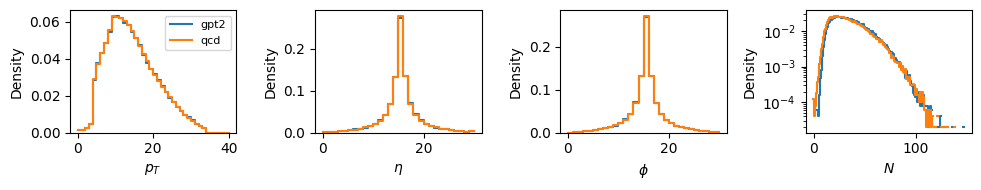

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize=(10, 2))
sns.histplot(qcd_gen_bins[...,0][qcd_gen_bins[...,0] >= 0],   bins=np.arange(0,41,1),  fill=False,   label='gpt2', element='step', stat='density', ax=ax[0])
sns.histplot(qcd_test_bins[...,0][qcd_test_bins[...,0] >= 0],  bins=np.arange(0,41,1),   fill=False, label='qcd', element='step', stat='density', ax=ax[0])
sns.histplot(qcd_gen_bins[...,1][qcd_gen_bins[...,0] >= 0],   bins=np.arange(0,31,1), fill=False,  label='gpt2', element='step', stat='density', ax=ax[1])
sns.histplot(qcd_test_bins[...,1][qcd_test_bins[...,0] >= 0],   bins=np.arange(0,31,1), fill=False,  label='test', element='step', stat='density', ax=ax[1])
sns.histplot(qcd_gen_bins[...,2][qcd_gen_bins[...,0] >= 0], bins=np.arange(0,31,1), fill=False,  label='gpt2', element='step', stat='density', ax=ax[2])
sns.histplot(qcd_test_bins[...,2][qcd_test_bins[...,0] >= 0],  bins=np.arange(0,31,1), fill=False, label='test', element='step', stat='density', ax=ax[2])
sns.histplot((qcd_gen_seq != -1).sum(dim=1), discrete=True, bins=np.arange(0,120,1),  fill=False,  label='gpt2', element='step', stat='density', ax=ax[3], log_scale=(False, True))
sns.histplot((qcd_test_seq != -1).sum(dim=1), discrete=True, bins=np.arange(0,120,1),  fill=False,  label='test', element='step', stat='density', ax=ax[3], log_scale=(False, True))

ax[0].set_xlabel(r'$p_T$')
ax[1].set_xlabel(r'$\eta$')
ax[2].set_xlabel(r'$\phi$')
ax[3].set_xlabel(r'$N$')

ax[0].legend(fontsize=8)

plt.tight_layout()
plt.show()

### binned data

In [51]:
tops_test_bins[...,1].max()

tensor(30)

In [78]:
def make_continues(jets,bin_tag):
    pt_bins = np.load("preprocessing_bins/pt_bins_"+str(bin_tag)+".npy")
    eta_bins = np.load("preprocessing_bins/eta_bins_"+str(bin_tag)+".npy")
    phi_bins = np.load("preprocessing_bins/phi_bins_"+str(bin_tag)+".npy")

    pt_disc = jets[:, :, 0]
    mask = pt_disc >= 0
    eta_disc = jets[:, :, 1]
    phi_disc = jets[:, :, 2]

    pt_con = pt_disc * (pt_bins[1] - pt_bins[0]) + pt_bins[0]
    eta_con = eta_disc * (eta_bins[1] - eta_bins[0]) + eta_bins[0]
    phi_con = phi_disc * (phi_bins[1] - phi_bins[0]) + phi_bins[0]

    continues_jets = np.stack((np.exp(pt_con), eta_con, phi_con), -1)
    continues_jets[mask] = 0

    return continues_jets

-0.7724137950000001

In [5]:
pt_qcd_tokens = qcd_gen_bins[...,0]
eta_qcd_tokens = qcd_gen_bins[...,1]
phi_qcd_tokens = qcd_gen_bins[...,2]

In [14]:
# open yaml file

import yaml

def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print(f"Error reading YAML file: {e}")
            return None

bin_edges = read_yaml_file('bin_edges.yaml')


In [45]:

eta_binned = []
for idxs in qcd_gen_bins[...,1]:
    etas = []
    for i in idxs:
        if i==30:
            eta_binned.append(30)

## Log-p computation

In [4]:
tops_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{sig_id}/checkpoints/best.ckpt")
tops_gpt2.top_k = 5000 #tops_gpt2.start_token # remove top_k default cut
tops_gpt2.to("cuda:1")

qcd_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{bkg_id}/checkpoints/best.ckpt")
qcd_gpt2.top_k = 5000 #qcd_gpt2.start_token # remove top_k default cut
qcd_gpt2.to("cuda:0")

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/tokenized-jets/17eab02a204343a3969183034847009d/checkpoints/best.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/tokenized-jets/301a89ea04ba46f59c2f39f34ff5f9b9/checkpoints/best.ckpt`


JetGPT2Model(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(39405, 256)
      (wpe): Embedding(201, 256)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-7): 8 x GPT2Block(
          (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D(nf=768, nx=256)
            (c_proj): Conv1D(nf=256, nx=256)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=1024, nx=256)
            (c_proj): Conv1D(nf=256, nx=1024)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=256, out_features

### logp's on gen data

In [5]:
#...ROC curve

tops_logp_on_qcd = tops_gpt2.log_probs(qcd_gen_seq, batch_size=32, device=tops_gpt2.device)
tops_logp_on_tops = tops_gpt2.log_probs(tops_gen_seq, batch_size=32, device=tops_gpt2.device)
qcd_logp_on_qcd = qcd_gpt2.log_probs(qcd_gen_seq, batch_size=32, device=qcd_gpt2.device)
qcd_logp_on_tops = qcd_gpt2.log_probs(tops_gen_seq, batch_size=32, device=qcd_gpt2.device)

/home/df630/SyntheticJets/utils.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")


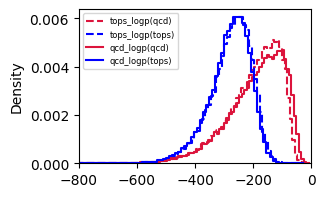

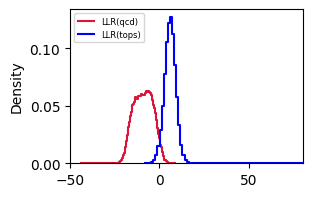

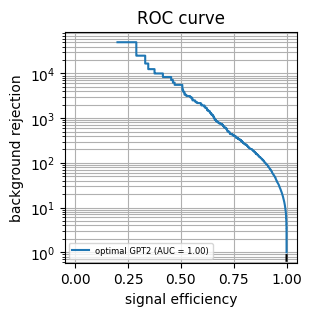

In [6]:
from utils  import ROC
import seaborn as sns

log = False
plt.figure(figsize=(3, 2))

sns.histplot(tops_logp_on_qcd, bins=100, ls='--', fill=False,label='tops_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(tops_logp_on_tops, bins=100, ls='--',fill=False, label='tops_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
sns.histplot(qcd_logp_on_qcd, bins=100, fill=False,  label='qcd_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(qcd_logp_on_tops, bins=100, fill=False,  label='qcd_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-800, 0)

LLR_tops = tops_logp_on_tops - qcd_logp_on_tops    
LLR_qcd = tops_logp_on_qcd - qcd_logp_on_qcd   

plt.figure(figsize=(3, 2))

sns.histplot(LLR_qcd, bins=100, fill=False,label='LLR(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(LLR_tops, bins=100,fill=False, label='LLR(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-50, 80)


plt.figure(figsize=(3, 3))
ROC(LLR_qcd, LLR_tops, "optimal GPT2")
plt.grid(True,which='both')
plt.legend(fontsize=6, loc="lower left")

/home/df630/SyntheticJets/utils.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")


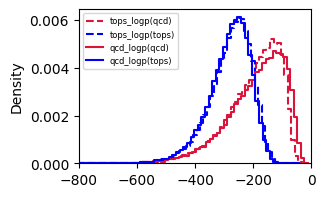

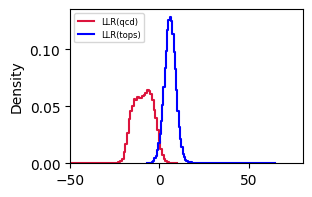

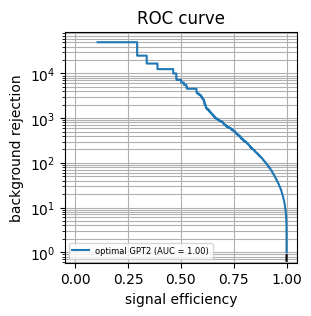

In [4]:
from utils  import ROC
import seaborn as sns

log = False
plt.figure(figsize=(3, 2))

sns.histplot(tops_logp_on_qcd, bins=100, ls='--', fill=False,label='tops_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(tops_logp_on_tops, bins=100, ls='--',fill=False, label='tops_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
sns.histplot(qcd_logp_on_qcd, bins=100, fill=False,  label='qcd_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(qcd_logp_on_tops, bins=100, fill=False,  label='qcd_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-800, 0)

LLR_tops = tops_logp_on_tops - qcd_logp_on_tops    
LLR_qcd = tops_logp_on_qcd - qcd_logp_on_qcd   

plt.figure(figsize=(3, 2))

sns.histplot(LLR_qcd, bins=100, fill=False,label='LLR(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(LLR_tops, bins=100,fill=False, label='LLR(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-50, 80)


plt.figure(figsize=(3, 3))
ROC(LLR_qcd, LLR_tops, "optimal GPT2")
plt.grid(True,which='both')
plt.legend(fontsize=6, loc="lower left")


### logp's on test data

In [3]:
tops_logp_on_qcd = tops_gpt2.log_probs(qcd_test_seq, batch_size=32, device=tops_gpt2.device)
tops_logp_on_tops = tops_gpt2.log_probs(tops_test_seq, batch_size=32, device=tops_gpt2.device)
qcd_logp_on_qcd = qcd_gpt2.log_probs(qcd_test_seq, batch_size=32, device=qcd_gpt2.device)
qcd_logp_on_tops = qcd_gpt2.log_probs(tops_test_seq, batch_size=32, device=qcd_gpt2.device)

/home/df630/SyntheticJets/utils.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")


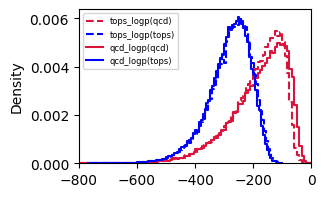

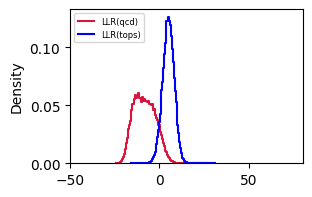

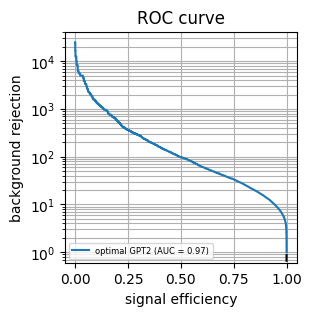

In [4]:
from utils  import ROC
import seaborn as sns

log = False
plt.figure(figsize=(3, 2))

sns.histplot(tops_logp_on_qcd, bins=100, ls='--', fill=False,label='tops_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(tops_logp_on_tops, bins=100, ls='--',fill=False, label='tops_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
sns.histplot(qcd_logp_on_qcd, bins=100, fill=False,  label='qcd_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(qcd_logp_on_tops, bins=100, fill=False,  label='qcd_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-800, 0)

LLR_tops = tops_logp_on_tops - qcd_logp_on_tops    
LLR_qcd = tops_logp_on_qcd - qcd_logp_on_qcd   

plt.figure(figsize=(3, 2))

sns.histplot(LLR_qcd, bins=100, fill=False,label='LLR(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(LLR_tops, bins=100,fill=False, label='LLR(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-50, 80)


plt.figure(figsize=(3, 3))
ROC(LLR_qcd, LLR_tops, "optimal GPT2")
plt.grid(True,which='both')
plt.legend(fontsize=6, loc="lower left")